# Cross Section Interface

The PyNE library offers a convenient interface for calculating and caching multigroup neutron cross sections, regardless of the data source used. These cross sections can be computed from various available data sources, which are stored in the `nuc_data.h5` file. The cross section interface remains consistent across all data sources, allowing users to easily switch between different cross section libraries.

PyNE provides support for the following cross section formats:

- ENDF file format (experimental)
- ACE file format
- EAF 175-group cross sections
- CINDER 63-group cross sections
- Two-point fast/thermal interpolation (using `simple_xs` data from KAERI)
- Physical models
- Null data

This functionality can be accessed through the `xs` sub-package, which is further divided into the following modules:

`models:` This module provides physical cross-section models and helper functions.

`data_source:` Interfaces for accessing data sources of cross section libraries.

`cache:` This module offers a cross-section cache that automates the extraction of cross-section data from supplied nuclear data sets.

`channels:` This module offers a user-friendly interface for efficiently retrieving multigroup cross sections from the cross section cache and collapsing them to match the desired group structure. It also provides interfaces for higher-level functionalities, including cross-section computation for materials, fission energy spectra, metastable ratios, and more.

## Data Sources

Data sources are a type of class that offers a standardized interface for retrieving cross-section data from a particular data source. By default, this retrieval process is lazily evaluated, meaning that the data is fetched only when needed. Additionally, the data source object serves as an in-memory cache, allowing subsequent access to the raw data to be faster.

To better understand the functioning of data sources, let's consider an example where we retrieve some known data. 

### EAF Data Source

In [1]:
from pyne.xs.data_source import EAFDataSource, SimpleDataSource, NullDataSource

In [2]:
eds = EAFDataSource()
# reaction returns a dictionary containing source group structure, energy values, 
# cross-section data, and interpolation data.
gamma = eds.reaction('U235', 'gamma')
gamma

array([3.40601e-04, 4.13527e-04, 4.52339e-04, 5.35260e-04, 7.79656e-04,
       9.12824e-04, 1.05027e-03, 1.20057e-03, 1.33202e-03, 1.46200e-03,
       1.60595e-03, 1.67206e-03, 1.76457e-03, 1.90211e-03, 2.03703e-03,
       2.12614e-03, 2.15500e-03, 2.15923e-03, 2.17015e-03, 2.19708e-03,
       2.24992e-03, 2.34009e-03, 2.47761e-03, 2.65621e-03, 2.80624e-03,
       2.93429e-03, 3.18937e-03, 3.54963e-03, 3.99022e-03, 4.53866e-03,
       5.21324e-03, 6.05776e-03, 7.06523e-03, 9.26177e-03, 1.27481e-02,
       1.75162e-02, 2.23344e-02, 2.54474e-02, 2.88533e-02, 3.21686e-02,
       3.59024e-02, 4.03127e-02, 4.31805e-02, 4.57085e-02, 4.57084e-02,
       4.57112e-02, 4.87787e-02, 5.18315e-02, 5.62859e-02, 6.08943e-02,
       6.55405e-02, 7.01358e-02, 7.41851e-02, 7.78783e-02, 8.13216e-02,
       8.57563e-02, 8.88694e-02, 9.13386e-02, 9.53971e-02, 9.82263e-02,
       1.00158e-01, 1.04962e-01, 1.08964e-01, 1.11877e-01, 1.14201e-01,
       1.16384e-01, 1.19622e-01, 1.23457e-01, 1.27270e-01, 1.317

The data source also provides a method to re-discretize this data to another group structure.

In [3]:
import numpy as np
dst_e_g = np.logspace(1, -7, 11)

# dst_group_struct is the group structure of the destination cross sections.
eds.dst_group_struct = dst_e_g

# discreatizes the reaction channel from the source group structure to that of the
# destination, weighted by the group fluxes.
gamma_c = eds.discretize('U235', 'gamma')
print(gamma_c)
print(dst_e_g)

[2.52625773e-02 1.50668227e-01 3.94173552e-01 8.29069757e-01
 2.08402584e+00 5.56199103e+00 1.73480167e+01 3.37415300e+01
 1.01908466e+01 2.15494273e+01]
[1.00000000e+01 1.58489319e+00 2.51188643e-01 3.98107171e-02
 6.30957344e-03 1.00000000e-03 1.58489319e-04 2.51188643e-05
 3.98107171e-06 6.30957344e-07 1.00000000e-07]


Now let's plot it!

In [4]:
from pyne.bins import stair_step
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('font', family='serif', size=14)


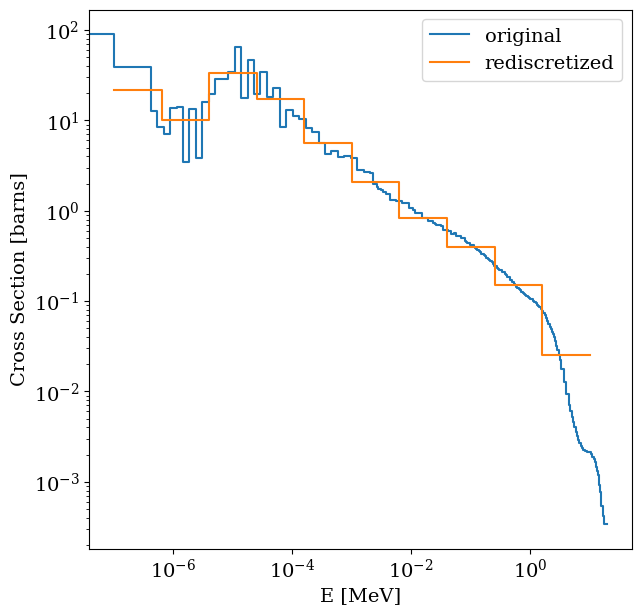

In [5]:
fig = plt.figure(figsize=(7,7))
plt.loglog(*stair_step(eds.src_group_struct, gamma), figure=fig) # original
plt.loglog(*stair_step(eds.dst_group_struct, gamma_c), figure=fig) # new group structure
plt.xlabel('E [MeV]')
plt.ylabel('Cross Section [barns]')
plt.legend(('original', 'rediscretized'))

### Simple Data Source

This interface is independent of where the data came from. As it should be!

In [6]:
sds = SimpleDataSource(dst_group_struct=dst_e_g)
print(sds.exists)
rx = sds.reaction('U233', 'absorption') # cross section data
rxc = sds.discretize('U233', 'absorption') # discretization of data

True


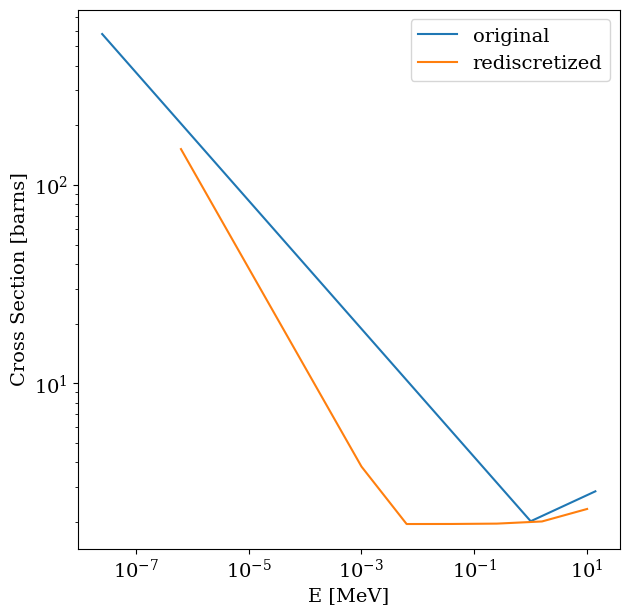

In [7]:
fig = plt.figure(figsize=(7,7))
plt.loglog(sds.src_group_struct[:-1], rx, figure=fig)
plt.loglog(sds.dst_group_struct[:-1], rxc, figure=fig)
plt.xlabel('E [MeV]')
plt.ylabel('Cross Section [barns]')
plt.legend(('original', 'rediscretized'))

Since data sources are caches, subsequent requests for 
the same data are very fast! 

In [8]:
%time sds.reaction('U238', 'fiss')
print
%time sds.reaction('U238', 'fission')
print
%time sds.reaction('U238', 'fiss')
print

CPU times: user 12.9 ms, sys: 372 µs, total: 13.3 ms
Wall time: 12.1 ms
CPU times: user 15 µs, sys: 6 µs, total: 21 µs
Wall time: 22.4 µs
CPU times: user 8 µs, sys: 3 µs, total: 11 µs
Wall time: 13.4 µs


<function print(*args, sep=' ', end='\n', file=None, flush=False)>

## Cross Section Caching

Now suppose you want to discretize data and retrieve cross sections from multiple sources, prioritizing data availability, you can utilize the `XSCache` class. 

This class functions similarly to a dictionary, where the keys are tuples in the form of `(nuclide, rx)` or `(nuclide, rx, temp)`. These tuples represent the specific nuclide, reaction ID, and temperature for which you require information.



In [9]:
from pyne.xs.cache import XSCache

In [10]:
xscache = XSCache(group_struct=dst_e_g,
                  data_sources=[EAFDataSource, SimpleDataSource, NullDataSource])


In [11]:
xscache['U235', 'abs']

array([  1.94057774,   1.71230641,   2.02444418,   3.24912017,
         7.42318537,  20.15919429,  51.8621376 ,  77.11455565,
        46.99610069, 155.69532222])

If you request a cross-section that is not present in the cache (doesn't exist), the system will return an array containing 0 values.

In [12]:
xscache['H42', 'gamma']

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Reading ACE Files

To load data from an ACE file, one needs to simply initialize an instance of the `Library` class specifying the path to the `Library` file:

    from pyne import ace
    libFile = ace.Library('endf70a')
    libFile.read()
    

## Reading ENDF Files
Similarly, ENDF file reading and cross-section discretization is supported.

In [13]:
import requests
from pyne.xs.data_source import ENDFDataSource
from pyne import nucname
from os.path import isfile

# Download the data file if it isn't there
if not isfile("Ni59.txt"):
    r = requests.get("http://t2.lanl.gov/nis/data/data/ENDFB-VII.1-neutron/Ni/59")
    with open("Ni59.txt", "wb") as outfile:
        outfile.write(r.content)

In [14]:
endfds = ENDFDataSource("Ni59.txt")

# get the nonelastic reaction data for Ni-59
nonelastic_rx = endfds.reaction("Ni59", "nonelastic")

# set the group structure and re-discretize
nonelastic_rx['dst_group_struct'] = np.logspace(7, -5, 33)
nonelastic_c = endfds.discretize("Ni59", "nonelastic")

Now let's plot it!!


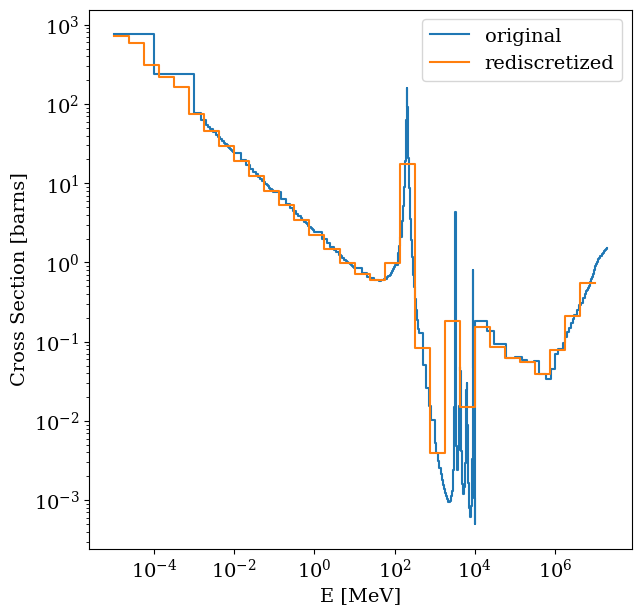

In [15]:
fig = plt.figure(figsize=(7,7))

# e_int is the array of energy values over which to integrate
E_g = nonelastic_rx['e_int']

# xs is the array of cross-sections corresponding to e_int
nonelastic = nonelastic_rx['xs']

# with base group structure
plt.loglog(*stair_step(E_g, nonelastic[:-1]), figure=fig) 

# discretized with new group structure
plt.loglog(*stair_step(nonelastic_rx['dst_group_struct'], nonelastic_c), figure=fig) 
plt.xlabel('E [MeV]')
plt.ylabel('Cross Section [barns]')
plt.legend(('original', 'rediscretized'))

## Cross Section Channels

The `pyne.xs.channels` module in PyNE offers a user-friendly interface for efficiently accessing multigroup cross sections from the cross section cache and collapsing them to match the desired group structure. This module includes various functions, such as:

`sigma_f`: Calculates the neutron fission cross section for a nuclide.

`sigma_s_gh`: Calculates the neutron scattering kernel for a nuclide.

`sigma_s`: Calculates the neutron scattering cross section for a nuclide.

`sigma_a_reaction`: Calculates the neutron absorption reaction cross section for a nuclide.

`sigma_a`: Calculates the neutron absorption cross section for a nuclide.

`sigma_t`: Calculates the total neutron cross section for a nuclide.

`chi`: Calculates the neutron fission energy spectrum for a nuclide.

`metastable_ratio`: Calculates the ratio between a reaction that leaves the nuclide in a metastable state and the equivalent reaction that leaves the nuclide in the ground state.  

Unlike the standard cache view, the functions in the channels module provide extended capabilities. In addition to retrieving cross sections, you can also compute cross sections for materials, fission energy spectra, metastable ratios, and more. This module enhances the flexibility and convenience of accessing and manipulating cross section data in PyNE.

In [16]:
from pyne.xs import channels
from pyne.material import Material, from_atom_frac

In [17]:
fuel = from_atom_frac({'U235': 0.045, 'U238': 0.955, 'O16': 2.0}, mass=1.0, density=10.7)

# the cross section is mapped to fuel with group structure dist_e_g
# the default temp is 300K; this uses a group flux.
channels.sigma_f(fuel, group_struct=dst_e_g)

array([0.21836068, 0.11496041, 0.09857257, 0.09597528, 0.10104627,
       0.13585377, 0.22343296, 0.44344517, 0.99609454, 2.38428759])